# Financial Data Analysis - Documentation

### 0. Data Preparation
   - Sets up styles for plotting.
   - Downloads SPY price data from Yahoo Finance.
   - Calculates log daily returns and handles missing values.
   - Plots adjusted closing prices and log daily returns for visual inspection.

### 1. **Normality Test (Shapiro-Wilk)**  
   - Uses the Shapiro-Wilk test to check whether the log returns follow a normal distribution.  
   - Determines if the data deviates significantly from normality, which is critical for financial time series analysis.

### 2. **Fat Tails Test**  
   - Investigates the distribution's "fat tails" by analyzing statistical properties like skewness and kurtosis.  
   - Fat tails indicate higher probabilities of extreme events compared to a normal distribution, essential for risk management.

### 3. **Plotting Histogram with Estimated Density**  
   - A histogram of log returns is plotted alongside its estimated density to visualize the distribution.  
   - **Key Insight**: The distribution of log returns is closer to a t-distribution, showing positive skewness and fatter tails compared to a normal distribution.

### 4. **Stationarity Test (KPSS)**  
   - Performs the KPSS test to evaluate whether the log return series is stationary.  
   - Helps ensure that statistical models applied to the data are appropriate.

### 5. **GARCH Model**  
   - **Creating Pairs of (p, q) Parameters**:  
     - Selects \( p \) and \( q \) parameters for the GARCH model.  
   - **Function for Optimizing GARCH Parameters**:  
     - Defines a function to optimize GARCH parameters based on various mean models, volatility models, and distributions.

### 6. **Fitting the Optimized GARCH Model**  
   - Applies the optimized GARCH model to the log returns to analyze and model volatility.

### 7. **Deriving Coefficients**  
   - Extracts and analyzes coefficients from the GARCH model summary to assess their statistical significance.  

### 8. **Residual Analysis**  
   - Examines residuals for correlations and patterns using:  
     - Statistical tests, such as the Ljung-Box test.  
     - Visualizations like ACF and PACF plots.  

### 9. **Forecasting with the GARCH Model**  
   - Generates forecasts for future volatility over a defined horizon using the GARCH model.  
   - Compares the forecasts against actual data for evaluation.

### 10. **Visualization of Model Fit**  
   - Visualizes the GARCH model's fit to the data.  
   - Includes visualizations for both the entire dataset and specific subsets.

### 11. **References**  
   - [Python for Finance Cookbook (2nd Edition)](https://github.com/PacktPublishing/Python-for-Finance-Cookbook-2E)  
   - Various other sources, including GitHub related to financial time series forecasting.


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log_Returns
Date,,,,,,,
2019-01-08,256.820007,257.309998,254.000000,256.769989,233.633698,102512600,0.935148
2019-01-09,257.559998,258.910004,256.190002,257.970001,234.725571,95006600,0.466255
2024-12-30,587.890015,591.739990,584.409973,588.219971,588.219971,56578800,-1.147725
2024-12-31,589.909973,590.640015,584.419983,586.080017,586.080017,57052700,-0.364465


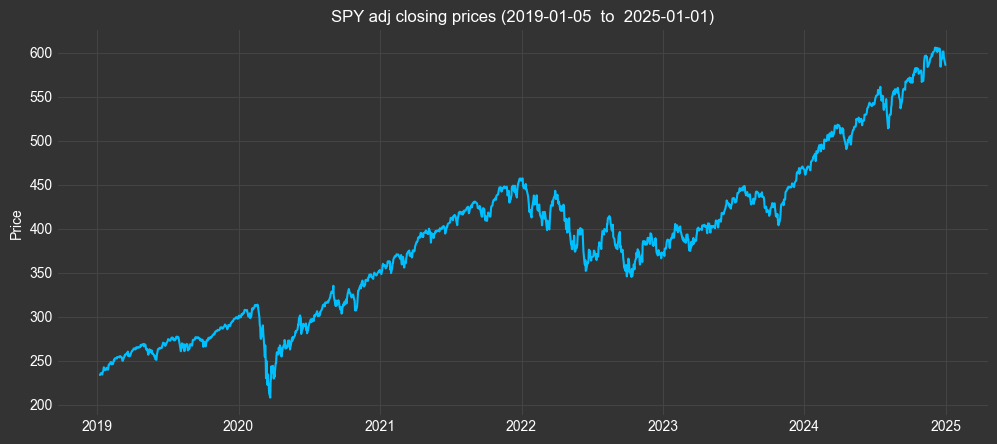

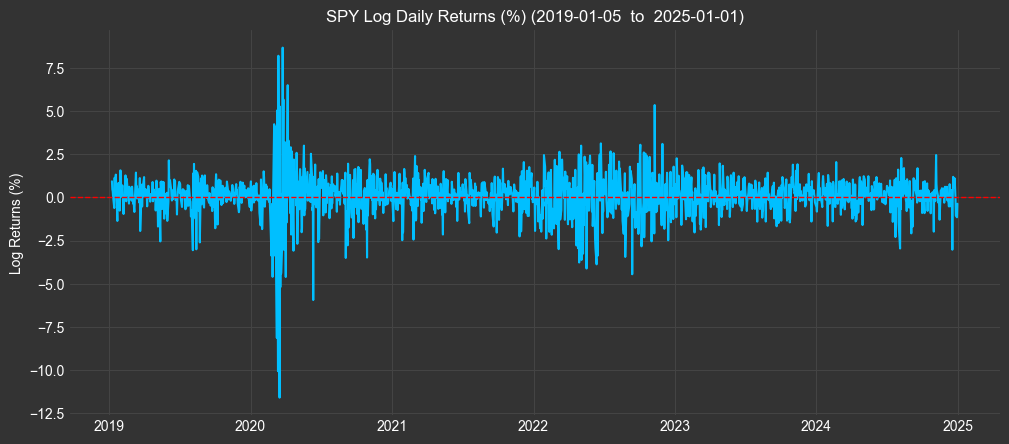

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = '#333333'
plt.rcParams['axes.facecolor'] = '#333333'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = '#444444'

# Download SPY price data from Yahoo Finance
start_date = "2019-01-05"
end_date = "2025-01-01"
ticker = "SPY"
spy_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log daily returns
spy_data['Log_Returns'] = 100 * np.log(spy_data['Adj Close'] / spy_data['Adj Close'].shift(1))

# Drop missing values (from the shift operation)
spy_data = spy_data.dropna()

### Plot Closing (adj) prices
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(spy_data['Adj Close'], color='deepskyblue')
ax.set(title="SPY adj closing prices ("+start_date+"  to  "+end_date+")", ylabel='Price')

# Preview first & last 2 rows
display(pd.concat([spy_data.head(2), spy_data.tail(2)]))

# Plot the log daily returns
plt.figure(figsize=(12,5))
plt.plot(spy_data.index, spy_data['Log_Returns'], label='Log Daily Returns (%)', color='deepskyblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("SPY Log Daily Returns (%) ("+start_date+"  to  "+end_date+")")
plt.ylabel("Log Returns (%)")
plt.show()


### Normality test (Shapiro-Wilk)

In [2]:
from scipy import stats

stats.shapiro(spy_data['Log_Returns'])

statistic, p_value = stats.shapiro(spy_data['Log_Returns'])

# Print Shapiro-Wilk test results
print("W-test Statistic:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("\nNormality absence.")
else:
    print("\nNormality presence.")

W-test Statistic: 0.8777606040297128
p-value: 7.965053724298341e-33

Normality absence.


### Fat tails test

In [3]:
print("Mean:", round(np.mean(spy_data['Log_Returns']), 4))
print("Standard Deviation:", round(np.std(spy_data['Log_Returns']), 4))
print("Skewness:", round(stats.skew(spy_data['Log_Returns']), 4))
print("Kurtosis:", round(stats.kurtosis(spy_data['Log_Returns']), 4))

Mean: 0.0617
Standard Deviation: 1.2508
Skewness: -0.854
Kurtosis: 13.37


### Ploting Histogram with estimated density

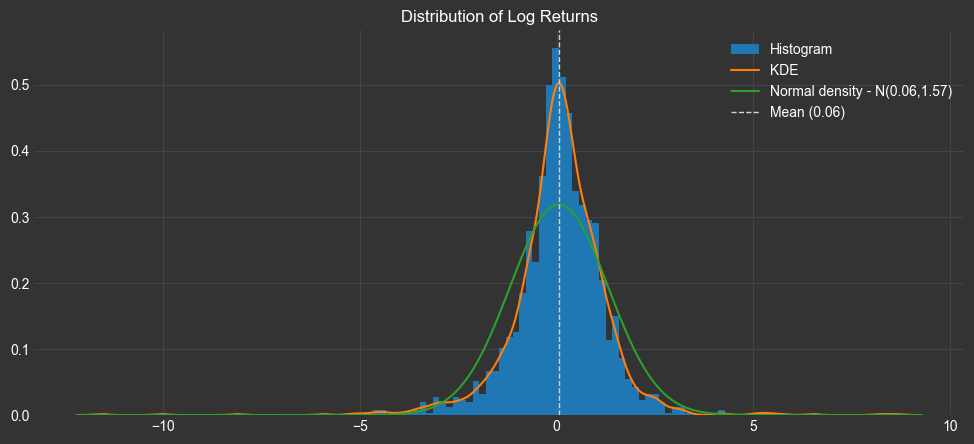

In [4]:
import statsmodels.api as sm
from scipy.stats import norm

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
hfig = ax.hist(spy_data['Log_Returns'], bins=120, density=True, label='Histogram')

kde = sm.nonparametric.KDEUnivariate(spy_data['Log_Returns'])
kde.fit()
ax.plot(kde.support, kde.density, label='KDE')

smean = np.mean(spy_data['Log_Returns'])
scal = np.std(spy_data['Log_Returns'], ddof=1)

normden = norm.pdf(kde.support, loc=smean, scale=scal)
ax.plot(kde.support, normden, label='Normal density - N('+str(round(smean, 2))+','+str(round(scal**2, 2))+')')

ax.axvline(smean, color='lightgray', linestyle='--', linewidth=1, label='Mean (' + str(round(smean, 2)) + ')')

ax.legend(loc='best')
ax.set(title='Distribution of Log Returns')
plt.show()

The distribution of Log Returns is closer to a t-distribution (positive skewed) with fatter tails than normal.

### Stationarity test (KPSS)

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss

# KPSS test
statistic, p_value, n_lags, critical_values = kpss(spy_data.Log_Returns, regression='c')

# Print KPSS results
print("KPSS Statistic:", statistic)
print("p-value:", p_value)
print("Critical Values:", critical_values)

if p_value < 0.05:
    print("\nStationarity absence.")
else:
    print("\nStationarity presence.")

KPSS Statistic: 0.05433616081484755
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Stationarity presence.


C:\Users\konstantinos\AppData\Local\Temp\ipykernel_15692\2708751401.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(spy_data.Log_Returns, regression='c')


#
# GARCH model
#

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Creating pairs of (p,q) parameters

In [7]:
# GARCH(p,q) with p<=2, q<=2 usually used (empirically)
ps = range(1, 10, 1)
qs = range(1, 10, 1)

order_list = list(product(ps, qs))
print(order_list[:5])

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]


### Function for optimizing GARCH parameters

In [8]:
from arch import arch_model
import pandas as pd
from typing import Union, List, Tuple
from tqdm.notebook import tqdm_notebook

def optimize_GARCH(endog: Union[pd.Series, list], order_list: List[Tuple[int, int]], volatility_model: List[str], distributions: List[str], mean_model: List[str]) -> pd.DataFrame:

    results = []
    for order in tqdm_notebook(order_list):
        for vol_mod in volatility_model:
            for distrib in distributions:
                for mean_mod in mean_model:
                    try:
                        model = arch_model(endog, p=order[0], q=order[1], mean=mean_mod, vol=vol_mod, dist=distrib)
                        
                        fitted = model.fit(disp='off', show_warning=False)
                        aic = fitted.aic
                        results.append([vol_mod, distrib, mean_mod, order, aic])

                    except Exception as e:
                        print(f"Failed for order {order}: {str(e)}")
                        continue
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['volatility_model', 'distribution', 'mean_model', '(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [9]:
# Different options for evaluation
mean_model = ['zero', 'constant']
volatility_model = ['GARCH', 'EGARCH']
distributions = ['normal', 'studentst', 'skewstudent']

result_df = optimize_GARCH(spy_data['Log_Returns'], order_list, volatility_model, distributions, mean_model)
result_df.head(10)

  0%|          | 0/81 [00:00<?, ?it/s]

,volatility_model,distribution,mean_model,"(p,q)",AIC
0,GARCH,skewstudent,constant,"(2, 1)",4104.161909
1,GARCH,skewstudent,constant,"(1, 1)",4105.886735
2,GARCH,skewstudent,constant,"(2, 2)",4106.133131
3,GARCH,skewstudent,constant,"(3, 1)",4106.161909
4,GARCH,skewstudent,constant,"(1, 2)",4107.886735
5,GARCH,skewstudent,constant,"(2, 3)",4108.009412
6,GARCH,skewstudent,constant,"(3, 2)",4108.097878
7,GARCH,skewstudent,constant,"(4, 1)",4108.161908
8,GARCH,skewstudent,constant,"(3, 3)",4108.948320
9,GARCH,skewstudent,constant,"(1, 3)",4109.886735


### Fitting optimized GARCH model on log returns

In [10]:
spy_data['Log_Returns'].name = "Log_Returns"

garch = arch_model(spy_data['Log_Returns'], vol=result_df.volatility_model[0], p=2, q=1, mean=result_df.mean_model[0], dist=result_df.distribution[0])
garchmod = garch.fit(disp='off')

print(garchmod.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                       Log_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2045.08
Distribution:      Standardized Skew Student's t   AIC:                           4104.16
Method:                       Maximum Likelihood   BIC:                           4141.38
                                                   No. Observations:                 1506
Date:                           Sat, Jan 11 2025   Df Residuals:                     1505
Time:                                   13:16:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

### Derive coefficients out of model summary

In [11]:
# Extracting GARCH Volatility Model Coeff P-Values from summary table
volatility_model_summary_table = garchmod.summary().tables[2]
coefficients_2 = volatility_model_summary_table.data[1:]
params_2 = [coef[0] for coef in coefficients_2]
p_values_2 = [float(coef[4]) for coef in coefficients_2]

# Extracting GARCH Mean Model Coeff P-Values from summary table
mean_model_summary_table = garchmod.summary().tables[1]
coefficients_1 = mean_model_summary_table.data[1:]
params_1 = [coef[0] for coef in coefficients_1]
p_values_1 = [float(coef[4]) for coef in coefficients_1]

# Extracting GARCH Distribution Coeff P-Values
distribution_summary_table = garchmod.summary().tables[3]
coefficients_3 = distribution_summary_table.data[1:]
params_3 = [coef[0] for coef in coefficients_3]
p_values_3 = [float(coef[4]) for coef in coefficients_3]

### Inspecting coefficients' significance visually

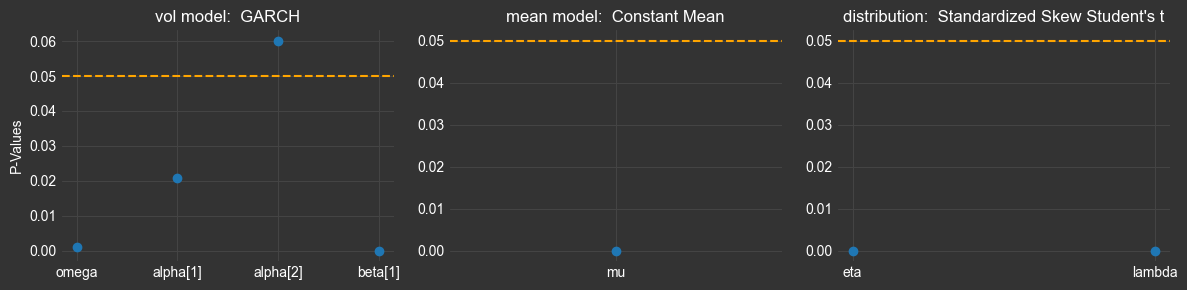

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot GARCH Volatility Model Coeff P-Values
axs[0].plot(params_2, p_values_2, marker='o', linestyle='None')
axs[0].axhline(0.05, color='orange', linestyle='--')
axs[0].set_title('vol model:  '+ garchmod.summary().tables[0].data[2][1])
axs[0].set_ylabel('P-Values')

# Plot GARCH Mean Model Coeff P-Values
axs[1].plot(params_1, p_values_1, marker='o', linestyle='None')
axs[1].axhline(0.05, color='orange', linestyle='--')
axs[1].set_title('mean model:  ' +garchmod.summary().tables[0].data[1][1])

# Plot GARCH Distribution Coeff P-Values
axs[2].plot(params_3, p_values_3, marker='o', linestyle='None')
axs[2].axhline(0.05, color='orange', linestyle='--')
axs[2].set_title('distribution:  ' +garchmod.summary().tables[0].data[3][1])

plt.tight_layout()
plt.show()

All parameters seem to be statistically significant (including alpha[2] marginally).

### Plot model fit to data

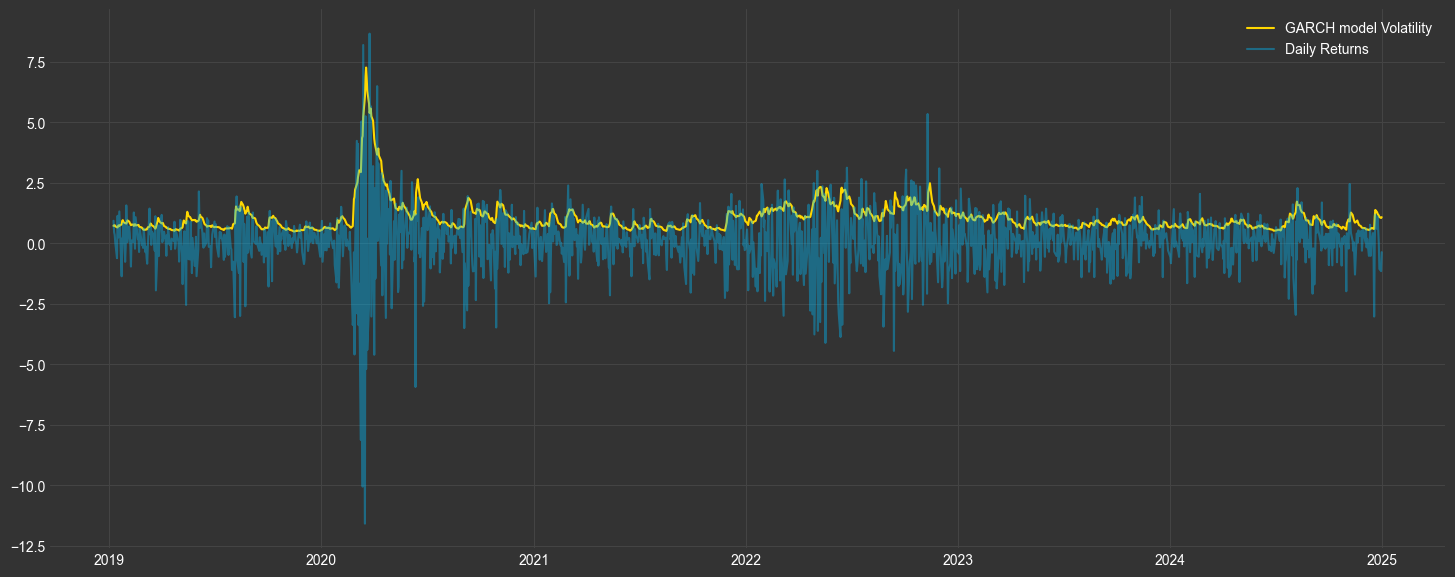

In [13]:
# Get model estimated volatility
garchmod_volatility = garchmod.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(18,7))
plt.plot(garchmod_volatility, color = 'gold', label = 'GARCH model Volatility')
plt.plot(spy_data['Log_Returns'], color = 'deepskyblue', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

### Plot model fit on first 500 bars (2 years)

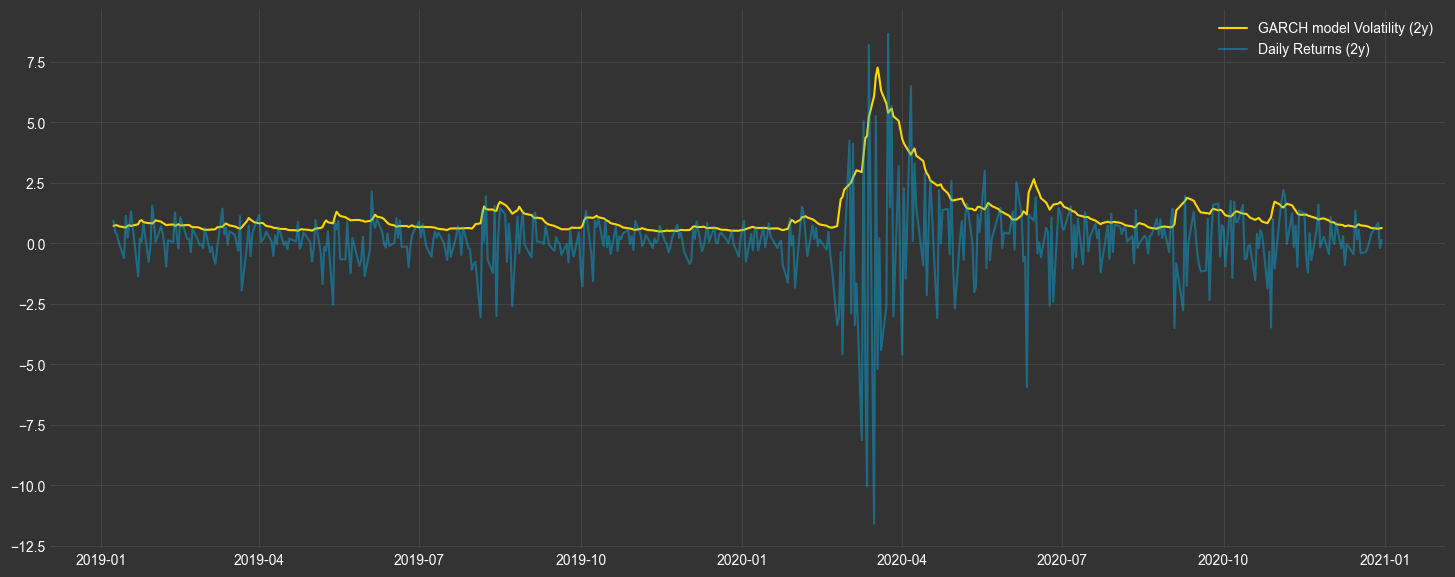

In [14]:
# Plot model fitting results
plt.figure(figsize=(18,7))
plt.plot(garchmod_volatility[:500], color = 'gold', label = 'GARCH model Volatility (2y)')
plt.plot(spy_data['Log_Returns'][:500], color = 'deepskyblue', label = 'Daily Returns (2y)', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

### Residual analysis

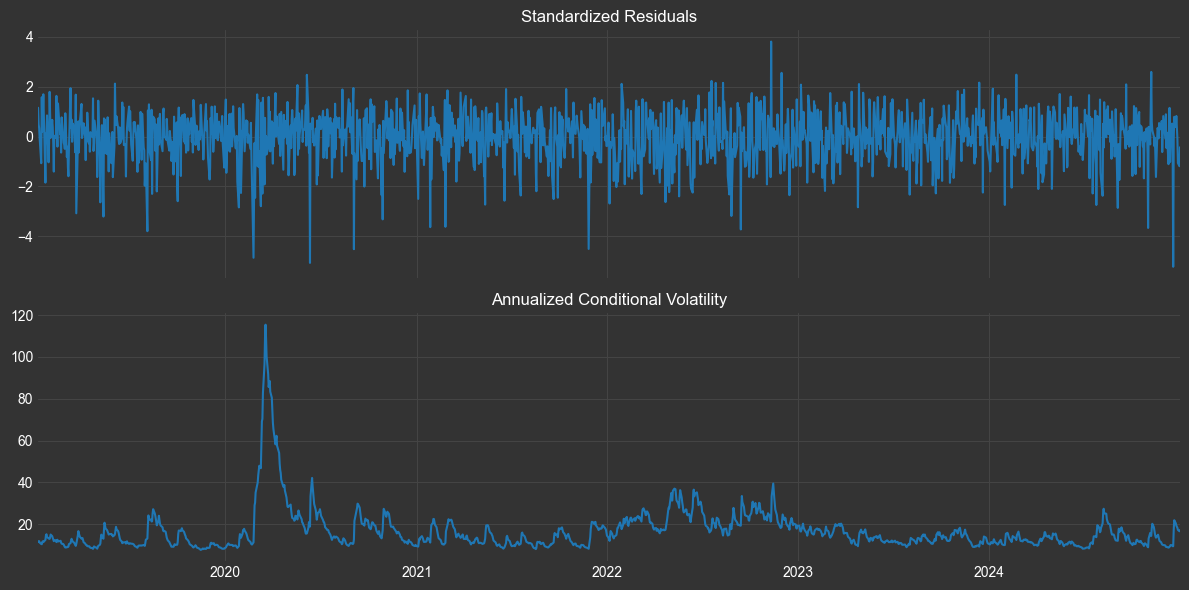

In [15]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 6]
garchmod.plot(annualize="D")

sns.despine()
plt.tight_layout()

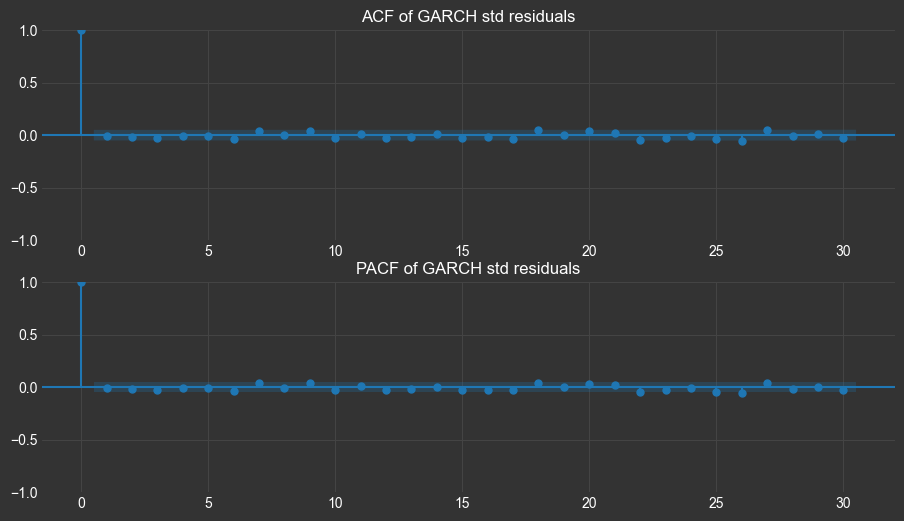

In [16]:
# Plot ACF and PACF of GARCH std residuals
fig, ax = plt.subplots(2, figsize=(11, 6))

plot_acf(garchmod.std_resid, ax=ax[0], lags=30, alpha=0.05, title="ACF of " + result_df.volatility_model[0] + " std residuals");

plot_pacf(garchmod.std_resid, ax=ax[1], lags=30, alpha=0.05, title="PACF of " + result_df.volatility_model[0] + " std residuals");

Uncorrelated std residuals.

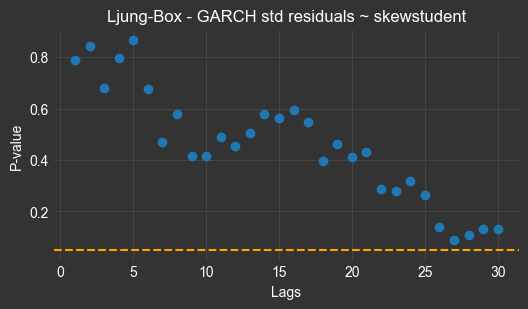


Autocorrelation absence.


In [17]:
# Ljung-Box test for GARCH std residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(garchmod.std_resid, lags=30, return_df=True)
lb_pvalues = lb_test['lb_pvalue']

plt.figure(figsize=(6,3))
plt.plot(lb_pvalues, marker='o', linestyle='None')
plt.axhline(0.05, color='orange', linestyle='--') # label="Significance Threshold (0.05)"
plt.title("Ljung-Box - GARCH std residuals ~ " + result_df.distribution[0])
plt.xlabel("Lags")
plt.ylabel("P-value")
plt.legend()
plt.show()

# If any p-value < 0.05 there is autocorrelation.
if any(element < 0.05 for element in lb_pvalues):
    print("\nAutocorrelation presence.")
else:
    print("\nAutocorrelation absence.")

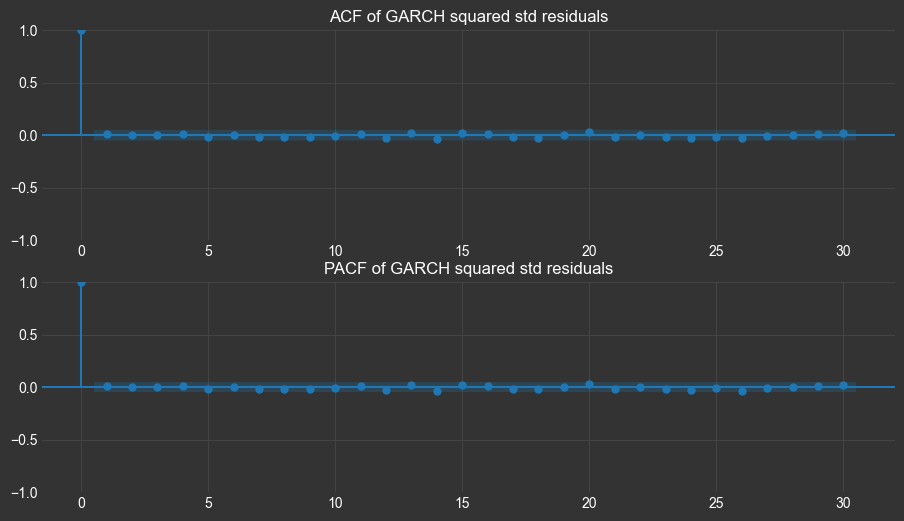

In [18]:
# Plot ACF-PACF of GARCH squared std residuals
fig, ax = plt.subplots(2, figsize=(11, 6))

plot_acf(garchmod.std_resid**2, ax=ax[0], lags=30, alpha=0.05, title="ACF of " + result_df.volatility_model[0] + " squared std residuals");

plot_pacf(garchmod.std_resid**2, ax=ax[1], lags=30, alpha=0.05, title="PACF of " + result_df.volatility_model[0] + " squared std residuals");

Uncorrelated squared std residuals.

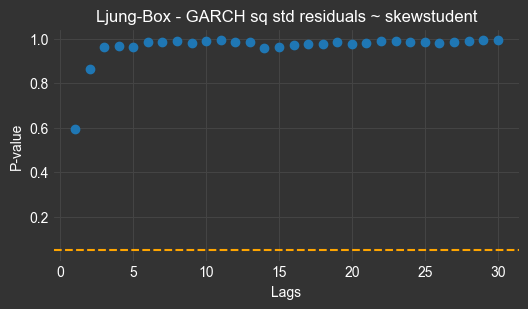


Autocorrelation absence.


In [19]:
# Ljung-Box for GARCH squared std residuals
lb_test = acorr_ljungbox(garchmod.std_resid**2, lags=30, return_df=True)
lb_pvalues = lb_test['lb_pvalue']

plt.figure(figsize=(6,3))
plt.plot(lb_pvalues, marker='o', linestyle='None') # label="Ljung-Box P-values"
plt.axhline(0.05, color='orange', linestyle='--') # label="Significance Threshold (0.05)"
plt.title("Ljung-Box - " + result_df.volatility_model[0] + " sq std residuals ~ " + result_df.distribution[0]) # ~ iidN(0, 1)
plt.xlabel("Lags")
plt.ylabel("P-value")
plt.legend()
plt.show()

# If any p-value < 0.05 there is autocorrelation.
if any(element < 0.05 for element in lb_pvalues):
    print("\nAutocorrelation presence.")
else:
    print("\nAutocorrelation absence.")

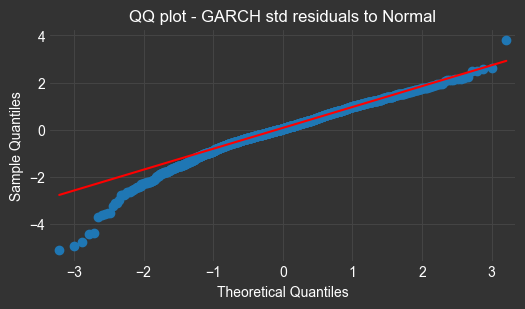

In [20]:
# QQ plot of GARCH std residuals to Normal
from statsmodels.graphics.api import qqplot

plt.rcParams['figure.figsize'] = [6, 3]
qqplot(garchmod.std_resid, line='q', fit=True)
plt.title("QQ plot - " + result_df.volatility_model[0] + " std residuals to Normal")
plt.show()

Signs for left side fat tails (deviation of Normal)

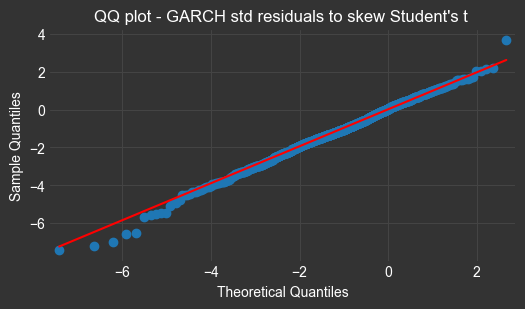

In [21]:
# QQ plot of GARCH std residuals to skew Student's t
from statsmodels.graphics.api import qqplot
from scipy.stats import jf_skew_t

qqplot(garchmod.std_resid, dist=stats.jf_skew_t, line='q', fit=True)
plt.title("QQ plot - " + result_df.volatility_model[0] + " std residuals to skew Student's t ")
plt.show()

Skew Student's t Considered as a better fit

### Split Log Returns data between Train - Test sets

In [22]:
train = spy_data['Log_Returns'][spy_data.index[0]:spy_data.index[99]]
test = spy_data['Log_Returns'][spy_data.index[100]:spy_data.index[129]]

In [23]:
train.name = "(train) Log_Returns"

garch_train_test = arch_model(train, vol=result_df.volatility_model[0], p=2, q=1, mean=result_df.mean_model[0], dist=result_df.distribution[0])
garchmod_train_test = garch_train_test.fit(disp='off')

print(garchmod_train_test.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:               (train) Log_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -104.832
Distribution:      Standardized Skew Student's t   AIC:                           223.665
Method:                       Maximum Likelihood   BIC:                           241.901
                                                   No. Observations:                  100
Date:                           Sat, Jan 11 2025   Df Residuals:                       99
Time:                                   13:16:23   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

### Generate forecasts

In [24]:
# Make N-period ahead forecast
forecast_horizon = 30
gm_forecast_train_test = garchmod_train_test.forecast(horizon = forecast_horizon, start = train.index[len(train)-1])

# Print the forecasted volatility (sqrt(variance))
np.sqrt(gm_forecast_train_test.variance.iloc[:, :5])

,h.01,h.02,h.03,h.04,h.05
Date,,,,,
2019-05-31,0.747951,0.822112,0.804117,0.795319,0.78689


In [25]:
# Set index to date and store forecasted volatility values in DataFrame
forecast_df = pd.DataFrame(np.sqrt(gm_forecast_train_test.variance[-1:]).values)
forecast_df.columns = pd.date_range(start=test.index[0], periods=forecast_horizon)
forecast_df = forecast_df.T
forecast_df.columns = ['Forecasted Volatility']
# Reseting index to include trading dates only
forecast_df.set_index(test.index, inplace=True)

display(pd.concat([forecast_df.head(1), forecast_df.tail(1)]))

,Forecasted Volatility
Date,
2019-06-03,0.747951
2019-07-15,0.727662


## Log Returns - Volatility Model - Forecasted Volatility

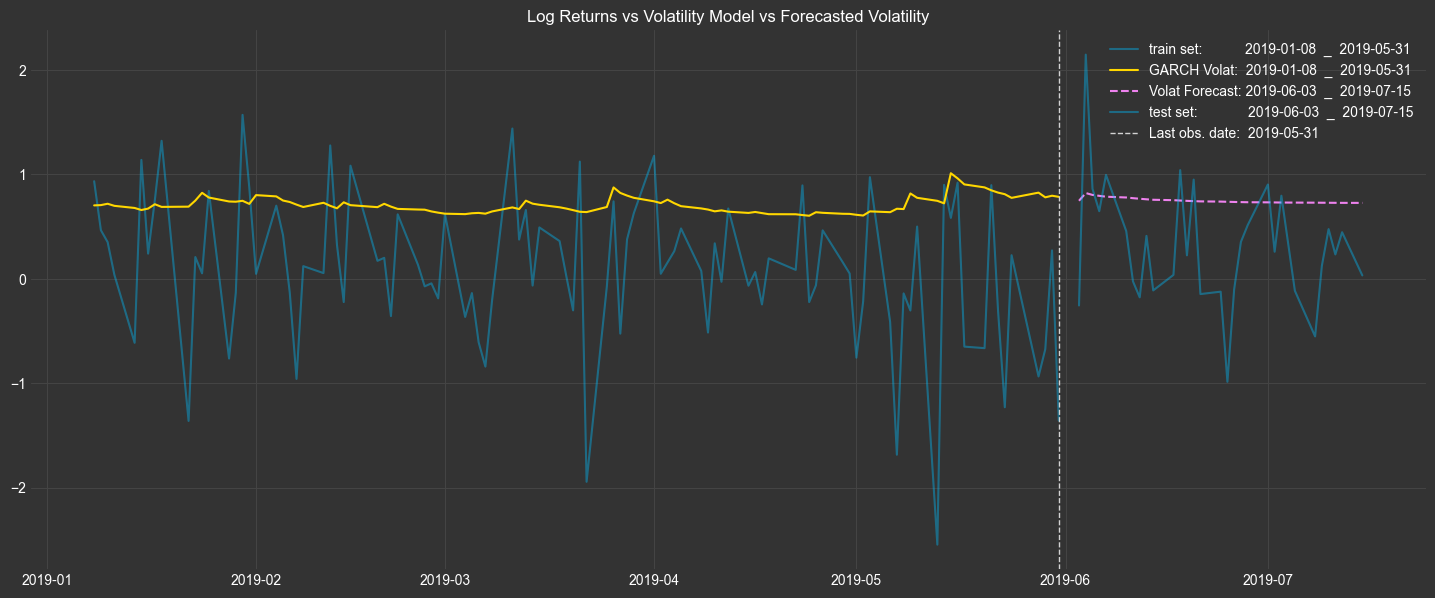

In [26]:
plt.figure(figsize=(18,7))

# Plot (train) Log Returns 100 days (~5 months) 
plt.plot(train, color = 'deepskyblue',
         label = 'train set:           ' +str(train.index[0].date())+ "  _  " +str(train.index[len(train)-1].date()), alpha = 0.4)

# Plot GARCH Volatility 100 days (~5 months)
plt.plot(garchmod_train_test.conditional_volatility, color = 'gold',
         label = 'GARCH Volat:  ' +str(train.index[0].date())+ "  _  " +str(train.index[len(train)-1].date()))

# Plot Forecasted Volatility 30 days (6 weeks) ahead of the last observation date
plt.plot(forecast_df, color = 'violet', linestyle = 'dashed',
         label = 'Volat Forecast: ' +str(forecast_df.index[0].date())+ "  _  " +str(forecast_df.index[len(forecast_df)-1].date()))

# Plot (test) Log Returns 30 days (6 weeks) to test forecasts
plt.plot(test, color = 'deepskyblue',
         label = 'test set:             ' +str(test.index[0].date())+ "  _  " +str(test.index[len(test)-1].date()), alpha = 0.4)

# Line to separate train and test
plt.axvline(train.index[len(train)-1].date(), color='lightgray', linestyle='--', linewidth=1, label='Last obs. date:  ' + str(train.index[len(train)-1].date()))

plt.title("Log Returns vs Volatility Model vs Forecasted Volatility")
plt.legend(loc = 'upper right', frameon=False)

Forecasts seem to stabilize around the mean (difficulty in forecasting volatility many days ahead)

##
## References

https://github.com/PacktPublishing/Python-for-Finance-Cookbook-2E

https://gist.github.com/hrishipoola/d96e4d6bc0b525231703541a49262216

https://github.com/marcopeix/TimeSeriesForecastingInPython

https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/tree/main

https://github.com/QuantLet/pyTSA/tree/main

https://github.com/PacktPublishing/Python-for-Finance-Second-Edition/tree/master